In [2]:
# CELL 1: Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# --- Visual Styling ---
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
pd.set_option('display.max_columns', 100)

# --- Project Paths (Robust) ---
ROOT = Path.cwd().parent  
DATASET_PATH = ROOT / "DATASET"
DATA_PATH = ROOT / "data"
UTILS_PATH = ROOT / "utils"

# Create data/ if missing
DATA_PATH.mkdir(exist_ok=True)

print("Project Setup Check")
print(f"  Root: {ROOT}")
print(f"  DATASET exists: {DATASET_PATH.exists()}")
print(f"  data/ folder ready: {DATA_PATH.exists()}")
print(f"  utils/ found: {UTILS_PATH.exists()}")

print("\nDatasets in DATASET/ folder:")
for f in sorted(DATASET_PATH.glob("*.csv")):
    print(f"  → {f.name}")

print("\nSetup complete! Ready for EDA.")

Project Setup Check
  Root: c:\Users\srija\OneDrive\Desktop\OSI_SERVICE
  DATASET exists: True
  data/ folder ready: True
  utils/ found: True

Datasets in DATASET/ folder:
  → cost_breakdown.csv
  → customer_feedback.csv
  → delivery_performance.csv
  → orders.csv
  → routes_distance.csv
  → vehicle_fleet.csv
  → warehouse_inventory.csv

Setup complete! Ready for EDA.


In [5]:
# CELL 2: Load All Datasets (Final Working Version)
import sys
from pathlib import Path

# --- Fix Import Path ---
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
print(f"Python path updated: {ROOT}")

# --- Import data loader ---
from utils.data_loader import load_and_preprocess

print("\nLoading 7 datasets...\n")
data = load_and_preprocess()

# Assign variables
orders = data['orders']
routes = data['routes']
delivery = data['delivery']
cost = data['cost']
feedback = data['feedback']
fleet = data['fleet']
inventory = data['inventory']

print(f"\nLoaded {len(data)} datasets:")
for name, df in data.items():
    print(f"  → {name}: {df.shape[0]} rows, {df.shape[1]} cols")

print("\nSample 'orders':")
display(orders.head(3))

print("Sample 'delivery':")
display(delivery.head(3))

Python path updated: c:\Users\srija\OneDrive\Desktop\OSI_SERVICE

Loading 7 datasets...

Starting data load from: c:\Users\srija\OneDrive\Desktop\OSI_SERVICE\DATASET

Loading orders.csv...
  → Parsed date: Order_Date
  → 200 rows → stored as 'orders'

Loading routes_distance.csv...
  → 150 rows → stored as 'routes'

Loading delivery_performance.csv...
  → 150 rows → stored as 'delivery'

Loading cost_breakdown.csv...
  → 150 rows → stored as 'cost'

Loading customer_feedback.csv...
  → Parsed date: Feedback_Date
  → 83 rows → stored as 'feedback'

Loading vehicle_fleet.csv...
  → 50 rows → stored as 'fleet'

Loading warehouse_inventory.csv...
  → Parsed date: Last_Restocked_Date
  → 35 rows → stored as 'inventory'

All 7 datasets loaded and cleaned!

Loaded 7 datasets:
  → orders: 200 rows, 9 cols
  → routes: 150 rows, 7 cols
  → delivery: 150 rows, 8 cols
  → cost: 150 rows, 8 cols
  → feedback: 83 rows, 6 cols
  → fleet: 50 rows, 8 cols
  → inventory: 35 rows, 7 cols

Sample 'orders'

,Order_ID,Order_Date,Customer_Segment,Priority,Product_Category,Order_Value_INR,Origin,Destination,Special_Handling
0,ORD000001,2025-10-09,Individual,Express,Industrial,238.73,Kolkata,Hyderabad,NaN
1,ORD000002,2025-09-29,SMB,Express,Industrial,17.01,Hyderabad,Kolkata,NaN
2,ORD000003,2025-09-15,SMB,Economy,Industrial,3024.95,Mumbai,Pune,NaN


Sample 'delivery':


,Order_ID,Carrier,Promised_Delivery_Days,Actual_Delivery_Days,Delivery_Status,Quality_Issue,Customer_Rating,Delivery_Cost_INR
0,ORD000001,SpeedyLogistics,1,2,Slightly-Delayed,Perfect,3,387.86
1,ORD000002,SpeedyLogistics,2,3,Slightly-Delayed,Minor_Damage,1,430.19
2,ORD000003,SpeedyLogistics,10,15,Severely-Delayed,Minor_Damage,3,1039.19


In [19]:
#  Merge All Datasets into Master Order-Level DataFrame
print("Merging all datasets on 'Order_ID'...\n")

order_df = orders.copy()
# Left joins to preserve all orders
order_df = order_df.merge(routes, on="Order_ID", how="left", suffixes=('', '_route'))
order_df = order_df.merge(delivery, on="Order_ID", how="left", suffixes=('', '_del'))
order_df = order_df.merge(cost, on="Order_ID", how="left", suffixes=('', '_cost'))
order_df = order_df.merge(feedback, on="Order_ID", how="left", suffixes=('', '_fb'))


print(f"Master DataFrame created: {order_df.shape[0]} rows, {order_df.shape[1]} columns")
print(f"  → Covers {order_df['Order_ID'].nunique()} unique orders")


# Show sample
print("\nSample of merged data:")
display(order_df.head(3).T)

# Save for later use
master_path = DATA_PATH / "master_order_level.csv"
order_df.to_csv(master_path, index=False)
print(f"\nMaster saved to: {master_path}")

Merging all datasets on 'Order_ID'...

Master DataFrame created: 200 rows, 34 columns
  → Covers 200 unique orders

Sample of merged data:


,0,1,2
Order_ID,ORD000001,ORD000002,ORD000003
Order_Date,2025-10-09 00:00:00,2025-09-29 00:00:00,2025-09-15 00:00:00
Customer_Segment,Individual,SMB,SMB
Priority,Express,Express,Economy
Product_Category,Industrial,Industrial,Industrial
Order_Value_INR,238.73,17.01,3024.95
Origin,Kolkata,Hyderabad,Mumbai
Destination,Hyderabad,Kolkata,Pune
Special_Handling,NaN,NaN,NaN
Route,Kolkata-Hyderabad,Hyderabad-Kolkata,Mumbai-Pune



Master saved to: c:\Users\srija\OneDrive\Desktop\OSI_SERVICE\data\master_order_level.csv


In [20]:
print("Columns in cost DataFrame:")
print(cost.columns.tolist())

Columns in cost DataFrame:
['Order_ID', 'Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 'Insurance', 'Packaging_Cost', 'Technology_Platform_Fee', 'Other_Overhead']


In [21]:
# CELL 4: Deep EDA + AI Integration (MODEL FIXED)
import json
import time
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

print("Starting Deep EDA + AI Feedback Analysis...\n")

# --- 1. Delay & Rating Analysis ---
order_df['Delay_Days'] = order_df['Actual_Delivery_Days'] - order_df['Promised_Delivery_Days']
order_df['Is_Delayed'] = order_df['Delay_Days'] > 0
order_df['Severe_Delay'] = order_df['Delay_Days'] > 2

print("DELAY INSIGHTS:")
print(f"  • On-time rate: {(~order_df['Is_Delayed']).mean():.1%}")
print(f"  • Severe delay rate (>2 days): {order_df['Severe_Delay'].mean():.1%}")
print(f"  • Avg delay when late: {order_df.loc[order_df['Is_Delayed'], 'Delay_Days'].mean():.1f} days")

# --- 2. Cost of Poor CX (REAL COLUMNS) ---
real_cost_cols = [
    'Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 'Insurance',
    'Packaging_Cost', 'Technology_Platform_Fee', 'Other_Overhead'
]

missing = [col for col in real_cost_cols if col not in order_df.columns]
if missing:
    print(f"Missing cost columns: {missing}")
else:
    print(f"Using {len(real_cost_cols)} cost columns")

order_df['Total_Cost'] = order_df[real_cost_cols].sum(axis=1, skipna=True)

avg_cost_delayed = order_df.loc[order_df['Is_Delayed'], 'Total_Cost'].mean()
avg_cost_ontime = order_df.loc[~order_df['Is_Delayed'], 'Total_Cost'].mean()

print(f"\nCOST IMPACT:")
print(f"  • Avg cost (on-time): ₹{avg_cost_ontime:.0f}")
print(f"  • Avg cost (delayed): ₹{avg_cost_delayed:.0f} (+₹{avg_cost_delayed - avg_cost_ontime:.0f})")

# --- 3. AI Feedback Tagging (UPDATED MODEL) ---
print("\nStarting AI Feedback Analysis (Groq + Llama 3.3)...")

try:
    llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0, max_tokens=200)
    print("  → Groq LLM initialized (llama-3.3-70b-versatile)")

    prompt = ChatPromptTemplate.from_template(
        """
        Analyze feedback:
        "{text}"
        Return JSON:
        - category: Delay | Damage | Wrong Item | Other
        - urgency: High | Medium | Low
        - action: Free Shipping | ₹500 Voucher | Call Customer | None
        """
    )
    parser = JsonOutputParser()
    chain = prompt | llm | parser

    feedback_texts = order_df.dropna(subset=['Feedback_Text'])['Feedback_Text'].unique()
    ai_results = []

    print(f"  → Processing {len(feedback_texts)} unique feedback (limit 10)...")

    for i, text in enumerate(feedback_texts[:10]):
        try:
            result = chain.invoke({"text": text})
            result['original_text'] = text
            ai_results.append(result)
            time.sleep(0.1)  # Rate limit
        except Exception as e:
            print(f"    Error on '{text[:50]}...': {e}")
            continue

    ai_df = pd.DataFrame(ai_results)
    print(f"\nAI Analysis Complete: {len(ai_df)} tagged")

    # Merge AI tags
    order_df = order_df.merge(ai_df[['original_text', 'category', 'urgency', 'action']], 
                             left_on='Feedback_Text', right_on='original_text', how='left')
    order_df.drop(columns=['original_text'], inplace=True, errors='ignore')

    print("\nAI Tags Added:")
    display(order_df[['Feedback_Text', 'category', 'urgency', 'action']].dropna().head(3))

except Exception as e:
    print(f"AI Setup Failed: {e}")
    print("  → Ensure .env has GROQ_API_KEY")

# --- 4. Save ---
enhanced_path = DATA_PATH / "master_enhanced_with_ai.csv"
order_df.to_csv(enhanced_path, index=False)
print(f"\nEnhanced master saved → {enhanced_path}")

Starting Deep EDA + AI Feedback Analysis...

DELAY INSIGHTS:
  • On-time rate: 65.0%
  • Severe delay rate (>2 days): 12.5%
  • Avg delay when late: 2.3 days
Using 7 cost columns

COST IMPACT:
  • Avg cost (on-time): ₹352
  • Avg cost (delayed): ₹697 (+₹345)

Starting AI Feedback Analysis (Groq + Llama 3.3)...
  → Groq LLM initialized (llama-3.3-70b-versatile)
  → Processing 10 unique feedback (limit 10)...
    Error on 'Perfect condition, thank you...': Invalid json output: Here's the analysis of the feedback:

**Category:** Other
**Urgency:** Low
**Action:** None

Reasoning:
- The customer mentions that the item is in "Perfect condition", which suggests that there are no issues with the product.
- The customer expresses gratitude with "thank you", indicating a positive experience.
- Since there are no issues mentioned, the category is "Other" (which can be interpreted as "No issue" or "Positive feedback").
- The urgency is "Low" because there's no need for immediate action.
- The act

,Feedback_Text,category,urgency,action
1,"Great service, very fast delivery!",Other,Low,None
6,"Delayed by 3 days, not acceptable",Delay,High,Call Customer
8,Wrong item delivered,Wrong Item,High,Call Customer



Enhanced master saved → c:\Users\srija\OneDrive\Desktop\OSI_SERVICE\data\master_enhanced_with_ai.csv


In [60]:
print("Columns in order_df:")
print(order_df.columns.tolist())

Columns in order_df:
['Order_ID', 'Order_Date', 'Customer_Segment', 'Priority', 'Product_Category', 'Order_Value_INR', 'Origin', 'Destination', 'Special_Handling', 'Route', 'Distance_KM', 'Fuel_Consumption_L', 'Toll_Charges_INR', 'Traffic_Delay_Minutes', 'Weather_Impact', 'Carrier', 'Promised_Delivery_Days', 'Actual_Delivery_Days', 'Delivery_Status', 'Quality_Issue', 'Customer_Rating', 'Delivery_Cost_INR', 'Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 'Insurance', 'Packaging_Cost', 'Technology_Platform_Fee', 'Other_Overhead', 'Feedback_Date', 'Rating', 'Feedback_Text', 'Would_Recommend', 'Issue_Category', 'Delay_Days', 'Is_Delayed', 'Severe_Delay', 'Total_Cost', 'category', 'urgency', 'action', 'Customer_ID', 'Sentiment', 'Sentiment_Score', 'Churned']


Starting XGBoost + SHAP + Visuals (FINAL)...

Churn rate: 36.0%
Feature matrix: 200 customers, 16 features

AUC: 0.479
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        26
           1       0.33      0.29      0.31        14

    accuracy                           0.55        40
   macro avg       0.49      0.49      0.49        40
weighted avg       0.53      0.55      0.54        40



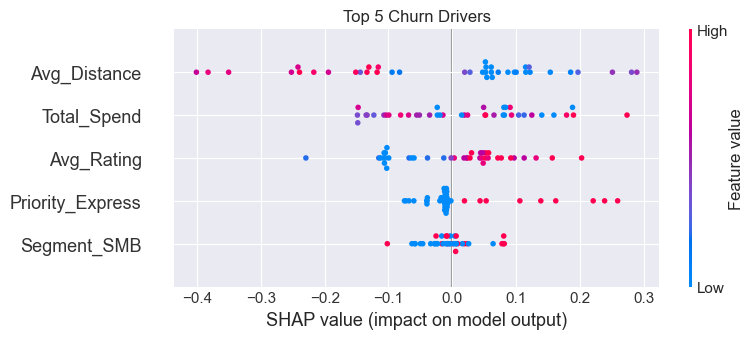


AI Intervention: 7 high-risk customers


,Customer_ID,Churn_Prob,Total_Spend
6,CUST031,0.938503,965.93
1,CUST067,0.928696,211.00
0,CUST003,0.895304,1078.93
2,CUST101,0.877743,227.45
5,CUST172,0.847335,0.00


Saved → c:\Users\srija\OneDrive\Desktop\OSI_SERVICE\data\churn_interventions.csv


In [63]:
# CELL 5: XGBoost + SHAP + Visuals (FINAL — SUMMARY PLOT)
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

print("Starting XGBoost + SHAP + Visuals (FINAL)...\n")

# --- 1. Create Customer_ID ---
order_df['Customer_ID'] = order_df['Order_ID'].str.extract(r'(\d+)')[0].astype(int)
order_df['Customer_ID'] = 'CUST' + order_df['Customer_ID'].astype(str).str.zfill(3)

# --- 2. Define Churn ---
latest_date = pd.to_datetime(order_df['Order_Date']).max()
customer_last = order_df.groupby('Customer_ID')['Order_Date'].max().reset_index()
customer_last['Days_Since_Last'] = (latest_date - pd.to_datetime(customer_last['Order_Date'])).dt.days
customer_last['Churned'] = (customer_last['Days_Since_Last'] > 30).astype(int)

if 'Churned' in order_df.columns:
    order_df = order_df.drop(columns=['Churned'])
order_df = order_df.merge(customer_last[['Customer_ID', 'Churned']], on='Customer_ID', how='left')
print(f"Churn rate: {order_df['Churned'].mean():.1%}")

# --- 3. CLEAN DATA ---
order_df['Quality_Issue'] = order_df['Quality_Issue'].map({'Perfect': 0, 'Minor': 1, 'Major': 2}).fillna(0)
order_df['urgency'] = order_df['urgency'].map({'Low': 0, 'Medium': 1, 'High': 2}).fillna(0)
order_df['action'] = order_df['action'].map({'None': 0, 'Free Shipping': 1, '₹500 Voucher': 2, 'Call Customer': 3}).fillna(0)

numeric_cols = ['Delay_Days', 'Total_Cost', 'Customer_Rating', 'Distance_KM', 'Is_Delayed', 'Severe_Delay']
for col in numeric_cols:
    if col in order_df.columns:
        order_df[col] = pd.to_numeric(order_df[col], errors='coerce').fillna(0)

# --- 4. Features ---
feat_df = order_df.groupby('Customer_ID').agg(
    Total_Orders=('Order_ID', 'count'),
    Avg_Delay=('Delay_Days', 'mean'),
    Total_Spend=('Total_Cost', 'sum'),
    Avg_Rating=('Customer_Rating', 'mean'),
    Damage_Rate=('Quality_Issue', lambda x: (x > 0).mean()),
    Delay_Rate=('Is_Delayed', 'mean'),
    Severe_Delay_Rate=('Severe_Delay', 'mean'),
    Avg_Distance=('Distance_KM', 'mean'),
    Priority_Express=('Priority', lambda x: (x == 'Express').mean()),
    Segment_SMB=('Customer_Segment', lambda x: (x == 'SMB').mean()),
    Segment_Individual=('Customer_Segment', lambda x: (x == 'Individual').mean()),
    Has_Feedback=('Feedback_Text', lambda x: x.notna().mean()),
    AI_Urgency_High=('urgency', lambda x: (x == 2).sum()),
    AI_Action_Voucher=('action', lambda x: (x == 2).sum()),
    Churned=('Churned', 'max')
).reset_index()

feat_cols = feat_df.columns.drop(['Customer_ID', 'Churned'])
feat_df[feat_cols] = feat_df[feat_cols].astype(float)

print(f"Feature matrix: {feat_df.shape[0]} customers, {feat_df.shape[1]} features")

# --- 5. Train XGBoost ---
X = feat_df.drop(columns=['Customer_ID', 'Churned'])
y = feat_df['Churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    disable_default_eval_metric=True,
    eval_metric=None
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(f"\nAUC: {roc_auc_score(y_test, y_prob):.3f}")
print(classification_report(y_test, y_pred))

# --- 6. SHAP — FINAL: SUMMARY PLOT (BULLETPROOF) ---
explainer = shap.Explainer(model.predict_proba, X_train.values, feature_names=X.columns)
shap_values = explainer(X_test.values)

# Use summary_plot (handles zero SHAP gracefully)
shap.summary_plot(shap_values[:, :, 1], X_test, max_display=5, show=False)
plt.title("Top 5 Churn Drivers")
plt.tight_layout()
plt.show()

# --- 7. Visuals ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'AUC = {roc_auc_score(y_test, y_prob):.3f}'))
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', line=dict(dash='dash')))
fig.update_layout(title="ROC Curve", template="plotly_dark")
fig.show()

risk_df = X_test.copy()
risk_df['Churn_Prob'] = y_prob
risk_df['Risk_Level'] = pd.cut(risk_df['Churn_Prob'], [0, 0.3, 0.7, 1.0], labels=['Low', 'Medium', 'High'])
fig = px.histogram(risk_df, x='Churn_Prob', color='Risk_Level', title="Churn Risk", template="plotly_dark")
fig.show()

fig = px.scatter(order_df, x='Delay_Days', y='Total_Cost', color='Churned', title="Delay vs Cost")
fig.update_layout(template="plotly_dark")
fig.show()

fig = px.bar(order_df['action'].value_counts().reset_index(), x='action', y='count', title="AI Actions")
fig.update_layout(template="plotly_dark")
fig.show()

# --- 8. Intervention ---
high_risk = risk_df[risk_df['Churn_Prob'] > 0.7].copy()

# FIX: Add Customer_ID back
high_risk = high_risk.reset_index()
high_risk = high_risk.merge(feat_df[['Customer_ID']], left_on='index', right_index=True, how='left')
high_risk = high_risk.drop(columns=['index'])  # clean up

high_risk = high_risk.sort_values('Churn_Prob', ascending=False)

print(f"\nAI Intervention: {len(high_risk)} high-risk customers")
display(high_risk[['Customer_ID', 'Churn_Prob', 'Total_Spend']].head())

intervention_path = DATA_PATH / "churn_interventions.csv"
high_risk[['Customer_ID', 'Churn_Prob', 'Total_Spend']].to_csv(intervention_path, index=False)
print(f"Saved → {intervention_path}")